In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# --- CONFIG ---
DATASET_PATH = "/kaggle/input/utkface-new/UTKFace"

In [4]:
# --- Load and preprocess UTKFace images ---
def load_utkface_dataset(dataset_path, limit=None):
    images, ages = [], []
    filenames = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]
    
    if limit:
        filenames = filenames[:limit]
    
    for img_name in filenames:
        try:
            age = int(img_name.split('_')[0])
            img_path = os.path.join(dataset_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for Keras
            img = cv2.resize(img, (224, 224)) / 255.0
            images.append(img)
            ages.append(age)
        except:
            continue
    return np.array(images), np.array(ages)

In [6]:
print("Loading data...")
X, y = load_utkface_dataset(DATASET_PATH, limit=5000)  # Optional limit for speed

Loading data...


In [7]:
# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# --- Model ---
base_model = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(1)(x)  # Age regression output
model = Model(base_model.input, output)

In [11]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# --- Training ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
print("Training model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

Training model...
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 123s 913ms/step - loss: 1523.0096 - mae: 33.4890 - val_loss: 1618.4119 - val_mae: 34.2863
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - loss: 1533.9786 - mae: 33.5886 - val_loss: 1609.9164 - val_mae: 34.1622
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 867ms/step - loss: 1556.8441 - mae: 33.8707 - val_loss: 1601.4777 - val_mae: 34.0385
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 124s 998ms/step - loss: 1554.0593 - mae: 33.8468 - val_loss: 1593.0750 - val_mae: 33.9149
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 876ms/step - loss: 1513.9977 - mae: 33.5321 - val_loss: 1584.7155 - val_mae: 33.7914
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 867ms/step - loss: 1498.0977 - mae: 33.2627 - val_loss: 1576.4060 - val_mae: 33.6682
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 875ms/step - loss: 1522.5382 - mae: 33.5093 - val_loss: 1568.1270 - val_mae: 33.5450
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - loss: 1532.1622 - ma

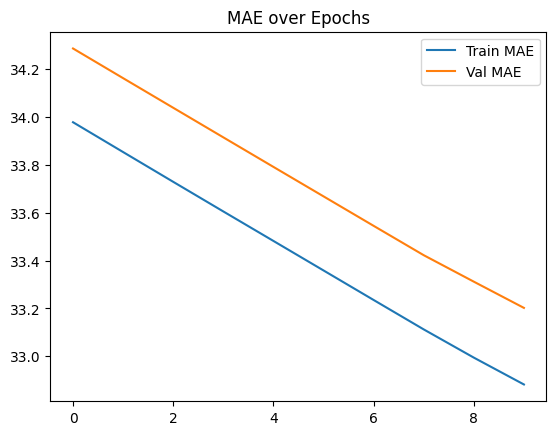

In [16]:
# ---Plot MAE ---
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("MAE over Epochs")
plt.legend()
plt.show()

In [17]:
# --- Save model if needed ---
model.save("/kaggle/working/age_model_mobilenet.h5")